In [1]:
import glob
import numpy  as np
import tables as tb
import matplotlib.pyplot as plt

from invisible_cities.database import load_db

from invisible_cities.reco.corrections_new import read_maps
from invisible_cities.reco.corrections_new import apply_all_correction
from invisible_cities.reco.corrections_new import norm_strategy

In [2]:
# SELECT PMAPS
run = 7600
pmaps_dir = f"/home/gdiaz/IRENE_NOTEBOOKS/DATA/pmaps/{run}/trigger1/"

pmaps_files = glob.glob( pmaps_dir + "/*" )
pmaps_files.sort()

# SIPMs DATA
datasipm = load_db.DataSiPM("new", run)
all_sipms = datasipm.index.get_values()

X = datasipm["X"].values
Y = datasipm["Y"].values

# CORRECTION MAP
maps = read_maps("/home/gdiaz/IRENE_NOTEBOOKS/DATA/maps/map_7600.h5")
total_correction = apply_all_correction(maps, apply_temp=True)
#                                         norm_strat=norm_strategy.custom,
#                                         norm_value=10)

In [3]:
Uncorrected = []
Corrected   = []

n = 15
for file_number in range(n):
    print(f"File {file_number+1} / {n}", end="\r")
    
    pmaps = tb.open_file( pmaps_files[file_number] )
    S1   = pmaps.root.PMAPS.S1  .read()
    S2   = pmaps.root.PMAPS.S2  .read()
    S2Si = pmaps.root.PMAPS.S2Si.read()
    event_times = pmaps.root.Run.events.read()
    
    
    for event_time in event_times:
        # CUT 1S1 1S2
        s1pks = len( np.unique(S1[ S1["event"]==event_time[0] ]["peak"] ) )
        s2pks = len( np.unique(S2[ S2["event"]==event_time[0] ]["peak"] ) )

        if (s1pks == 1) & (s2pks == 1):

            s1pk = 0
            s2pk = 0

            # SELECT S1 WAVEFORM
            sel = (S1["event"]==event_time[0]) & (S1["peak"]==s1pk)
            s1_times = S1[sel]["time"]/1000
            s1_ene   = S1[sel]["ene"]
            S1_time = np.sum( s1_times * s1_ene ) / np.sum(s1_ene) 


            # SELECT S2 PMT WAVEFORM 
            sel = (S2["event"]==event_time[0]) & (S2["peak"]==s2pk)
            s2_times = S2[sel]["time"]/1000

            s2_pmt = S2[sel]["ene"] #/ np.sum(S2[sel]["ene"]*1)


            # SELECT  S2 SIPMS WAVEFORM
            sel = (S2Si["event"]==event_time[0])&(S2Si["peak"]==s2pk)
            sipms, idxs = np.unique(S2Si[sel]["nsipm"], return_index=True)
            sipm_wfs    = np.array( np.split(S2Si[sel], idxs[1:]) )

            s2_sipms = sipm_wfs["ene"]

        else: continue
            
            
        Zs = (s2_times-S1_time)/10
        assert s2_sipms.shape[1]==Zs.shape[0]
        
        
        E = []

        for slide, z in enumerate(Zs):
            sel_sipms = np.isin(all_sipms, sipms)

            Z = np.full(s2_sipms.shape[0], Zs[slide])
            T = np.full(s2_sipms.shape[0], event_time[1])

            corr_tot = total_correction(X[sel_sipms], Y[sel_sipms], Z, T)
            correction_factor = np.where(~np.isnan(corr_tot), corr_tot, 0)

            qi = s2_sipms[:, slide]
            Ecorrected = s2_pmt[slide] * np.sum( qi / np.sum(qi) * correction_factor )

            E.append(Ecorrected)
        E = np.array(E)
        
        
        Uncorrected.append( np.sum(s2_pmt) )
        
        E = np.where(~np.isnan(E), E, 0)
        Corrected  .append( np.sum(E)      )   
        
Corrected   = np.array( Corrected )
Uncorrected = np.array( Uncorrected)

/home/gdiaz/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


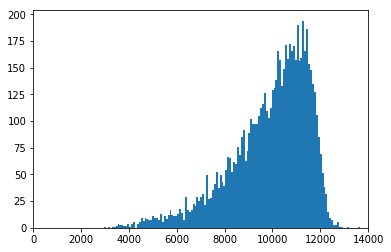

In [4]:
plt.hist(Uncorrected, bins=1000);
plt.xlim([0, 14000]);

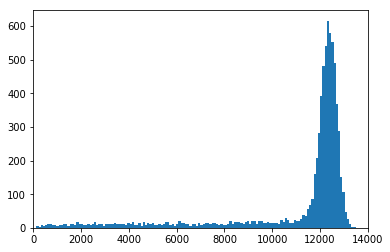

In [5]:
plt.hist(Corrected, bins=1000);
plt.xlim([0, 14000]);

In [6]:
Corrected

array([12254.59152012, 12324.88304978, 10446.46482882, ...,
        7071.17163483, 12049.68210121, 12194.84225918])